# Opis przedmiotu modelowania
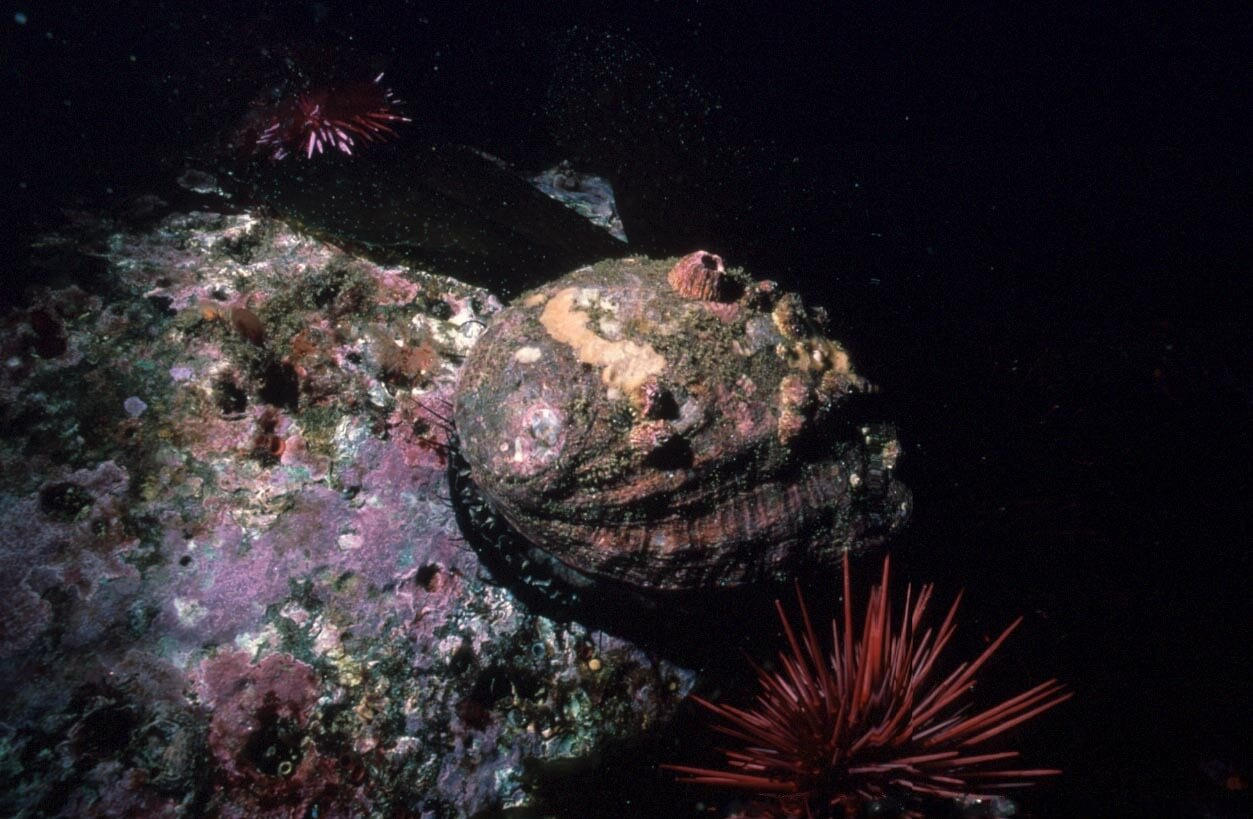

# Prezentacja danych
#### Ilość próbek:	4177
#### Ilość atrybutów: 9
#### Brakujące wartości: nie ma	
#### Problem: regresja
#### Dostępne atrybuty:
###### - Płeć (Sex) -	M, F, and I (infant)
###### - Długość (Length)
###### - Średnica (Diameter)
###### - Wysokość (Height)
###### - Waga całkowita (Whole weight)
###### - Waga mięsa (Shucked weight)
###### - Waga wnętrzności (Viscera weight) -	gut weight (after bleeding)
###### - Waga skorupy (Shell weight)
###### - Pierścienie (Rings 	+1.5 gives the age in years)

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import numpy as np

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

import xgboost as xg
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
        
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import patsy
from patsy import dmatrices, dmatrix, demo_data
import pickle

from xgboost import plot_tree
import graphviz

import statsmodels.api as sm
import statsmodels.formula.api as smf


**Wczytaj dane - w naszym przypadku dane o ślimakach**

In [5]:
df = pd.read_csv('dane_slimak.csv', encoding = 'utf-8', delim_whitespace=True)

# Data exploration 

In [6]:
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [7]:
df.info()
df.keys()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null object
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole_weight      4177 non-null float64
Shucked_weight    4177 non-null float64
Viscera_weight    4177 non-null float64
Shell_weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

In [8]:
df.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


# Data visualization

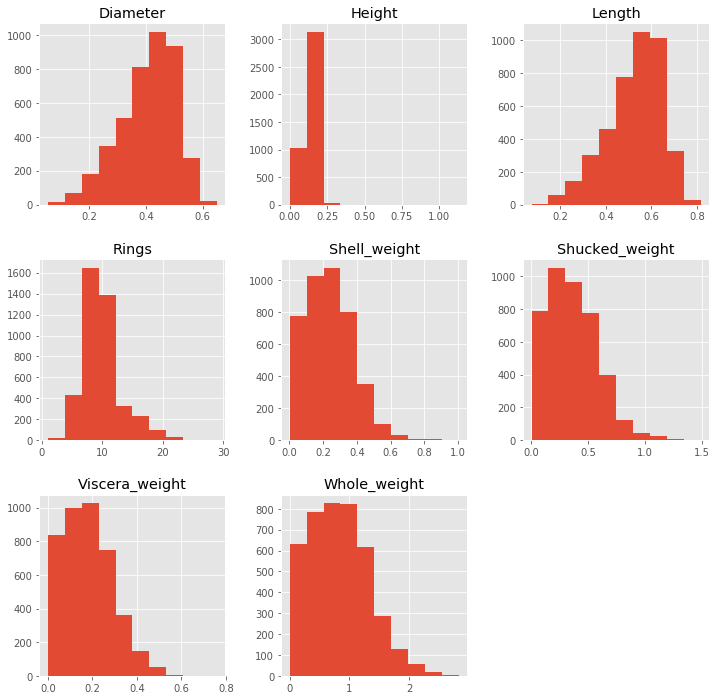

In [9]:
plt.style.use('ggplot')
pd.DataFrame.hist(df, figsize = [12,12])
plt.show()

### Macierz korelacji

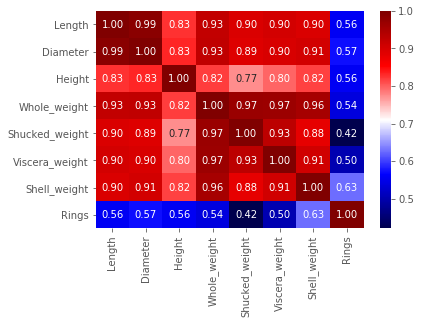

In [10]:
sns.heatmap(df.corr(), cmap = 'seismic', annot=True, fmt=".2f")

## Data Pre-Processing

**Zamień wartości na wartości liczbowe. w naszym wypadku jest to tylko 1 kolumna <płeć>**

In [11]:
df['Sex'].replace({'I': 2, 'F': 1, 'M': 0},inplace = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex               4177 non-null int64
Length            4177 non-null float64
Diameter          4177 non-null float64
Height            4177 non-null float64
Whole_weight      4177 non-null float64
Shucked_weight    4177 non-null float64
Viscera_weight    4177 non-null float64
Shell_weight      4177 non-null float64
Rings             4177 non-null int64
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


**Standaryzacja i wykrywanie wartości odstających**

In [31]:
df['Sex'] = df['Sex'].astype(float)
df['Rings'] = df['Rings'].astype(float)
ss = StandardScaler()
print(df.head())
df_scaled = pd.DataFrame(ss.fit_transform(df),columns = df.columns)
print(df_scaled.head())
outliers_rows, outliers_columns = np.where(np.abs(df_scaled)>3)

#wyświetlenie indeksów wierszy z potencjalnymi obserwacjami odstającymi
#print(outliers_rows)

print('\nIlość outlierów: {}'.format(len(outliers_rows)))

df = df[np.abs(df_scaled) <= 3]
df = df.dropna()
#print(df)

   Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
0  0.0   0.455     0.365   0.095        0.5140          0.2245   
1  0.0   0.350     0.265   0.090        0.2255          0.0995   
2  1.0   0.530     0.420   0.135        0.6770          0.2565   
3  0.0   0.440     0.365   0.125        0.5160          0.2155   
4  2.0   0.330     0.255   0.080        0.2050          0.0895   

   Viscera_weight  Shell_weight  Rings  
0          0.1010         0.150   15.0  
1          0.0485         0.070    7.0  
2          0.1415         0.210    9.0  
3          0.1140         0.155   10.0  
4          0.0395         0.055    7.0  
        Sex    Length  Diameter    Height  Whole_weight  Shucked_weight  \
0 -1.167886 -0.555103 -0.407883 -1.155431     -0.623339       -0.592432   
1 -1.167886 -1.456070 -1.445751 -1.290561     -1.255587       -1.198181   
2  0.038509  0.088444  0.162944 -0.074389     -0.266125       -0.437361   
3 -1.167886 -0.683813 -0.407883 -0.344649     -0.618956  

### Prepare features and target

In [32]:
columns_drop = ['Rings','Length']
X = df.drop(columns=columns_drop, axis = 1)
y = df['Rings']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state = 100)

### Funkcja błędu MAPE

In [34]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Patsy

In [35]:
train_X, test_X  = train_test_split(df,test_size=0.2, random_state=100)

###---------- interakcje ----------------------
f = 'Rings~Whole_weight*Length'
y, X = patsy.dmatrices(f,train_X, return_type="dataframe")
y_t, X_t = patsy.dmatrices(f,test_X, return_type="dataframe")

y = np.ravel(y)
y_t = np.ravel(y_t)

# # instantiate a XGBoost regression model, and fit with X and y
model = xg.XGBRegressor()
model = model.fit(X, y)

# # check the accuracy on the training set
pr = model.predict(X_t)

errors = (abs(pr - y_t)/y_t)*100
print('MAPE with interactions:',np.mean(errors))
#print(sm.OLS(y, X).fit().summary())
##------------- bez interakcji --------------------------

f = 'Rings~Whole_weight+Length'
y, X = patsy.dmatrices(f,train_X, return_type="dataframe")
y_t, X_t = patsy.dmatrices(f,test_X, return_type="dataframe")

y = np.ravel(y)
y_t = np.ravel(y_t)

# # instantiate a XGBoost regression model, and fit with X and y
model = xg.XGBRegressor()
model = model.fit(X, y)
#
# # check the accuracy on the training set
pr = model.predict(X_t)

errors = (abs(pr - y_t)/y_t)*100
print('MAPE without interactions:',np.mean(errors))
#WYNIKI XGBoost
# f = 'Rings~Shell_weight*Height' MAPE: 17.4472
# f = 'Rings~Shell_weight+Height' MAPE: 17.4952

# f = 'Rings~Diameter*Whole_weight' MAPE: 16.9314
# f = 'Rings~Diameter+Whole_weight' MAPE: 16.9696

# f = 'Rings~Diameter*Viscera_weight' MAPE:  17.4893
# f = 'Rings~Diameter+Viscera_weight' MAPE: 17.5508

# f = 'Rings~Whole_weight*Length' MAPE: 16.7179
#f = 'Rings~Whole_weight*Length' MAPE:  16.7524


###---------- interakcje wszystkie----------------------
f = 'Rings~Whole_weight*Length*Diameter*Height*Shucked_weight*Viscera_weight*Shell_weight'

y, X = patsy.dmatrices(f,train_X, return_type="dataframe")
y_t, X_t = patsy.dmatrices(f,test_X, return_type="dataframe")

y = np.ravel(y)
y_t = np.ravel(y_t)

# # instantiate a logistic regression model, and fit with X and y
model = xg.XGBRegressor()
model = model.fit(X, y)

# # check the accuracy on the training set
pr = model.predict(X_t)

errors = (abs(pr - y_t)/y_t)*100
print('MAPE with interactions:',np.mean(errors))
#print(sm.OLS(y, X).fit().summary())

MAPE with interactions: 17.49923806143078
MAPE without interactions: 17.417509954416946
MAPE with interactions: 14.509597752120696


## Modele 

## Linear regression


In [36]:
clf_linear = LinearRegression()
clf_linear.fit(X_train, y_train)
accuracy_linear = clf_linear.score(X_val, y_val)
y_pred_linear = clf_linear.predict(X_val)
mae_linear = mean_absolute_error(y_val, y_pred_linear)
mape_linear = mean_absolute_percentage_error(y_val, y_pred_linear)
# R2 - wsp determinacji
r2_linear = r2_score(y_val, y_pred_linear)
print('MAPE RF: %.2f' % mape_linear)
print('MAE RF:', mae_linear)
print('Metryka R2 (wariancji) RF : %.2f' % r2_linear)

MAPE RF: 15.23
MAE RF: 1.4566855269143957
Metryka R2 (wariancji) RF : 0.58


In [37]:
jobs = 100
n_splits = 10
data_linear = pd.DataFrame(columns=['n_jobs', 'cv_results'])
kfold = KFold(n_splits=n_splits, random_state=11)

for i in range(1,jobs + 1):
    for k in range(1, n_splits):
        
        clf_linear = LinearRegression(n_jobs = i)
        clf_linear.fit(X_train, y_train)
        y_pred_linear = clf_linear.predict(X_val)
        scorer = make_scorer(mean_absolute_error)
        cv_result = cross_val_score(clf_linear,X_train,y_train,cv = kfold,scoring=scorer)
        scorer = make_scorer(mean_absolute_error)
        cv_result = cross_val_score(clf_linear,X_train,y_train,cv = kfold,scoring=scorer)
        data_linear = data_linear.append({'n_jobs': i, 'cv_results': cv_result[k]}, ignore_index=True)

max_error = data_linear['cv_results'].max()
min_error = data_linear['cv_results'].min()

njobs_max = data_linear[data_linear.cv_results == max_error]
njobs_min = data_linear[data_linear.cv_results == min_error]

print('Max_error', max_error, 'wystepuje dla', njobs_max.iloc[0,0], 'n_jobs.')
print('Min_error', min_error, 'wystepuje dla', njobs_min.iloc[0,0], 'n_jobs.')

Max_error 1.5924529116791704 wystepuje dla 1.0 n_jobs.
Min_error 1.2984082151177754 wystepuje dla 1.0 n_jobs.


## SVR

In [38]:
clf_SVR = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf_SVR.fit(X_train, y_train)
y_pred_SVR = clf_SVR.predict(X_val)
#accuracy_SVR = clf_SVR.score( X_val,y_pred_SVR,)
mape_SVR = mean_absolute_percentage_error(y_val, y_pred_SVR)
mae_SVR = mean_absolute_error(y_val, y_pred_SVR)
r2_SVR = r2_score(y_val, y_pred_SVR)
print('MAPE RF: %.2f' % mape_SVR)
print('MAE RF:', mae_SVR)
print('Metryka R2 (wariancji) RF : %.2f' % r2_SVR)

MAPE RF: 14.81
MAE RF: 1.497407655496821
Metryka R2 (wariancji) RF : 0.52


In [39]:
#SVR
#Najlepsze wyniki otrzymano dla kernela = 'linear'. Parametr degree jest ignorowany, ponieważ
#stosuje sie dla 'polynomial'. Sprawdzono jeszcze max_iter.
#Min_error 1.412310635397532 wystepuje dla linear kernela. Najlepszy wynik dla max_iter = -1,
#czyli bez limitu iteracji. 

list_kernel = ['rbf', 'linear', 'poly', 'sigmoid']
max_iter = np.arange(-1,100, 1)
n_splits = 10
kfold = KFold(n_splits=n_splits, random_state=11)
df_results_SVR = pd.DataFrame(columns=['kernel', 'max_iter', 'results_SVR'])

#for i in max_iter:
for k in range(0, n_splits):
            clf_SVR = SVR(kernel= 'linear', max_iter= -1)
            clf_SVR.fit(X_train, y_train)
            y_pred_SVR = clf_SVR.predict(X_val)
            scorer = make_scorer(mean_absolute_error)
            results_SVR = cross_val_score(clf_SVR, X_train, y_train, cv=kfold, scoring=scorer)
            df_results_SVR = df_results_SVR.append({'kernel': 'linear', 'max_iter': -1, 'results_SVR': results_SVR[k]}, ignore_index=True)
            
max_error = df_results_SVR['results_SVR'].max()
min_error = df_results_SVR['results_SVR'].min()

iter_max = df_results_SVR[df_results_SVR.results_SVR == max_error]
iter_min = df_results_SVR[df_results_SVR.results_SVR == min_error]

print('Max_error', max_error, 'wystepuje dla', iter_max.iloc[0,0], 'iteracji.')
print('Min_error', min_error, 'wystepuje dla', iter_min.iloc[0,0], 'iteracji.')

Max_error 1.590487813761892 wystepuje dla linear iteracji.
Min_error 1.2456603159805524 wystepuje dla linear iteracji.


## Random Forest Regressor

In [40]:
clf_RFC = RandomForestRegressor(n_estimators=10, max_depth=10, min_samples_leaf=2, random_state=100)
clf_RFC.fit(X_train, y_train)
y_pred_RFC = clf_RFC.predict(X_val)
#accuracy_RFC = clf_RFC.score(y_val,y_pred_RFC)
mae_RFC = mean_absolute_error(y_val, y_pred_RFC)
mape_RFC = mean_absolute_percentage_error(y_val, y_pred_RFC)
r2_RFC = r2_score(y_val, y_pred_RFC)
print('MAPE RF: %.2f' % mape_RFC)
print('MAE RF:', mae_RFC)
print('Metryka R2 (wariancji) RF : %.2f' % r2_RFC)

MAPE RF: 15.52
MAE RF: 1.4472493499939352
Metryka R2 (wariancji) RF : 0.53


In [41]:
#randomforestregressor
#Min_error 1.493273713979974 wystepuje dla 49.0 estymatorow.
#Min_error 1.4645943427148402 wystepuje dla 49.0 glebokosci drzewa
#Min_error 1.4840924810037397 wystepuje dla 32.0 nodow.

n_estims = np.arange(1,100, 1)
max_depth = np.arange(1,100, 1)
leaf = np.arange(2,33,1)
n_splits = 5
kfold = KFold(n_splits=n_splits, random_state=11)
df_results_RFC = pd.DataFrame(columns=['n_estims', 'max_depth', 'max_leaf_nodes', 'results_RFC'])

#for i in n_estims:
#for i in max_depth:
for i in leaf:
        for k in range(0, n_splits):
            clf_RFC = RandomForestRegressor(n_estimators = 49, max_depth = 49, max_leaf_nodes = i)
            clf_RFC.fit(X_train, y_train)
            y_pred_RFC = clf_RFC.predict(X_val)
            scorer = make_scorer(mean_absolute_error)
            results_RFC = cross_val_score(clf_RFC, X_train, y_train, cv=kfold, scoring=scorer)
            df_results_RFC = df_results_RFC.append({'n_estims': 49, 'max_depth': 49, 'max_leaf_nodes': i, 'results_RFC': results_RFC[k]}, ignore_index=True)

max_error = df_results_RFC['results_RFC'].max()
min_error = df_results_RFC['results_RFC'].min()

leaf_max = df_results_RFC[df_results_RFC.results_RFC == max_error]
leaf_min = df_results_RFC[df_results_RFC.results_RFC == min_error]

print('Max_error', max_error, 'wystepuje dla', leaf_max.iloc[0,0], 'nodow.')
print('Min_error', min_error, 'wystepuje dla', leaf_min.iloc[0,0], 'nodow.')

Max_error 1.8580620948203053 wystepuje dla 49.0 nodow.
Min_error 1.2618567580041502 wystepuje dla 49.0 nodow.


## XGBoost

In [42]:
clf_XGB = xg.XGBRegressor()
clf_XGB.fit(X_train, y_train)
y_pred_XGB = clf_XGB.predict(X_val)
mae_XGB = mean_absolute_error(y_val, y_pred_XGB)
mape_XGB = mean_absolute_percentage_error(y_val, y_pred_XGB)
r2_XGB = r2_score(y_val, y_pred_XGB)

print('MAPE XBG: %.2f' % mape_XGB)
print('MAE XBG:', mae_XGB)
print('Metryka R2 (wariancji) XGB : %.2f' % r2_XGB)


MAPE XBG: 14.95
MAE XBG: 1.4232656778015704
Metryka R2 (wariancji) XGB : 0.58


### After hyperparameters adjustemnts

In [44]:
# min error on training data = 1.375106
# parameters nestim = 70;max_depth=4,learning_rate =0.05

clf_XGB = xg.XGBRegressor(max_depth=4,learning_rate=0.05,n_estimators=70, gamma = 7)
clf_XGB.fit(X_train, y_train)
y_pred_XGB = clf_XGB.predict(X_val)

mae_XGB = mean_absolute_error(y_val, y_pred_XGB)
mape_XGB = mean_absolute_percentage_error(y_val, y_pred_XGB)
r2_XGB = r2_score(y_val, y_pred_XGB)

print('MAPE XBG: %.2f' % mape_XGB)
print('MAE XBG:', mae_XGB)
print('Metryka R2 (wariancji) XGB : %.2f' % r2_XGB)


MAPE XBG: 14.45
MAE XBG: 1.415992431759094
Metryka R2 (wariancji) XGB : 0.57


### Cross-validation and hyperparameters for XGBoost

In [45]:
mds = np.arange(4,5)
lrs = np.arange(0.04,0.05,0.01)
n_estim = 70
n_splits = 10

params = list(itertools.product(mds,lrs))
n= len(params)

data = {"max_depth" : [], "learning_rate" :[], "mean_absolute_error":[]}

for i, (md,lr) in enumerate(params):
    model = xg.XGBRegressor(max_depth=md,learning_rate=lr,n_estimators=n_estim)
    cv = KFold(n_splits=n_splits)
    scorer = make_scorer(mean_absolute_error)
    cv_result = cross_val_score(model,X_train,y_train,cv=cv,scoring=scorer)

    data["mean_absolute_error"].extend(cv_result)
    data["max_depth"].extend([md]*n_splits)
    data["learning_rate"].extend([lr]*n_splits)
#   data["n_estim"].extend([n_estim]*n_splits)
    
    print("{}/{}".format(i,n))

df_hyper = pd.DataFrame.from_dict(data)
df_hyper = df_hyper.groupby(['max_depth','learning_rate']).mean()
print(df_hyper)

df = pd.DataFrame(data=data)
min_error = df["mean_absolute_error"].min()
max_error = df["mean_absolute_error"].max()

out = {
    "min_error":min_error,
    "max_error" : max_error,
    "df":df
}

0/2
1/2
                         mean_absolute_error
max_depth learning_rate                     
4         0.04                      1.391731
          0.05                      1.375106


In [ ]:
# nestim = 50;   4         0.05                      1.486244
# nestim = 100;  4         0.05                      1.498303
# nestim = 60;   4         0.05                      1.483301   
# nestim = 70;   4         0.05                      1.479858


### Feature importance

number of times each feature is split on across all boosting rounds (trees) in the model

[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_

[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[08:21:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_

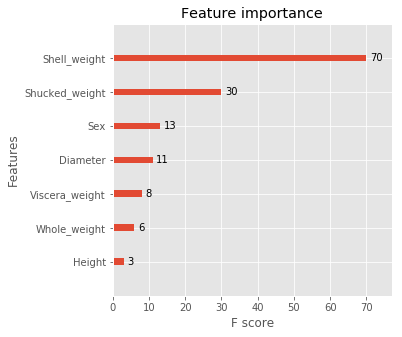

In [55]:
# Feature importance scores can be used for feature selection in scikit-learn.
# Next steps:
# use this to select features on the training dataset, train a model from the selected subset of features, 
# then evaluate the model on the testset, subject to the same feature selection scheme.

data_dmatrix = xg.DMatrix(data=X_train,label=y_train)

params = {"objective":"reg:linear",'learning_rate': 0.05,'n_estimators': 70,
                'max_depth': 4}

cv_results = xg.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=90,early_stopping_rounds=10,metrics="mae", as_pandas=True, seed=123)

xg_reg = xg.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xg.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## Decision Tree 

In [47]:
#DecisionTreeRegressor
clf_DTR = DecisionTreeRegressor()
clf_DTR.fit(X_train, y_train)
y_pred_DTR = clf_DTR.predict(X_val)

mae_DTR = mean_absolute_error(y_val, y_pred_DTR)
mape_DTR = mean_absolute_percentage_error(y_val, y_pred_DTR)
r2_DTR = r2_score(y_val, y_pred_DTR)
print('MAPE DTR: %.2f' % mape_DTR)
print('Metryka R2 (wariancji) DTR: %.2f' % r2_DTR)

MAPE DTR: 21.02
Metryka R2 (wariancji) DTR: 0.07


### After hyperparameters

In [49]:
#DecisionTreeRegressor
clf_DTR = DecisionTreeRegressor(max_depth=5,max_features=4, splitter='best')
clf_DTR.fit(X_train, y_train)
y_pred_DTR = clf_DTR.predict(X_val)

mae_DTR = mean_absolute_error(y_val, y_pred_DTR)
mape_DTR = mean_absolute_percentage_error(y_val, y_pred_DTR)
r2_DTR = r2_score(y_val, y_pred_DTR)
print('MAPE DTR: %.2f' % mape_DTR)
print('Metryka R2 (wariancji) DTR: %.2f' % r2_DTR)

MAPE DTR: 17.21
Metryka R2 (wariancji) DTR: 0.42


Text(0.5, 1.0, 'Average score: 1.5332739203838546')

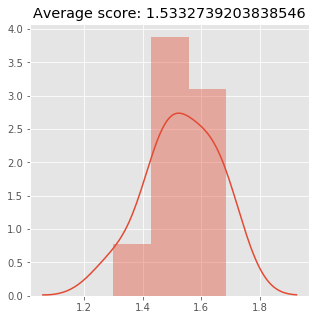

In [50]:
scorer = make_scorer(mean_absolute_error)

cv_scores = cross_val_score(clf_DTR, X_train, y_train, cv=10, scoring = scorer)

sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

scorer = make_scorer(mean_absolute_error)

parameter_grid = {
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(clf_DTR, param_grid=parameter_grid, cv=cross_validation,scoring = scorer)

grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

clf_DTR = grid_search.best_estimator_
clf_DTR

Best score: 2.012272709490871
Best parameters: {'max_depth': 2, 'max_features': 1, 'splitter': 'random'}


/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=1,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='random')

## Best model

In [62]:
clf_SVR = SVR(gamma='scale', C=1.0, epsilon=0.2,kernel='linear', max_iter= -1)
clf_SVR.fit(X_train, y_train)
y_pred_SVR = clf_SVR.predict(X_test)
mape_SVR = mean_absolute_percentage_error(y_test, y_pred_SVR)
mae_SVR = mean_absolute_error(y_test, y_pred_SVR)
r2_SVR = r2_score(y_test, y_pred_SVR)
print('MAPE RF: %.2f' % mape_SVR)
print('MAE RF:', mae_SVR)
print('Metryka R2 (wariancji) RF : %.2f' % r2_SVR)

MAPE RF: 15.14
MAE RF: 1.5699869492588934
Metryka R2 (wariancji) RF : 0.47
